## Test for nonlinear associations between gene expression and mechanical properties

Note: This notebook uses R.

- Compute local weighted median expression as gene expression metric, and pressure/stress tensor ranking as mechanical property metric
- Use scHOT (Ghazanfar *et al*, 2020) to identify significant **nonlinear** associations between gene expression and mechanical property metrics
- Cluster significant gene-property associations to identify shared modules with distinct patterns of association

In [1]:
dataset <- 'dataset3'

### Preprocessing

#### Library imports

In [2]:
suppressWarnings(suppressMessages(library(scHOT)))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(stringr)))
suppressWarnings(suppressMessages(library(BuenColors)))
suppressWarnings(suppressMessages(library(doParallel)))
suppressWarnings(suppressMessages(library(dynamicTreeCut)))
suppressWarnings(suppressMessages(library(clusterProfiler)))
suppressWarnings(suppressMessages(library(org.Mm.eg.db)))
source('helper_functions.R')

In [3]:
tensionmap_res <- read.table(paste0('../reproduce_data/', dataset, '/tensionmap_res.csv', collapse=''), sep=',', header = T, row.names = 1)
gex_res <- read.table(paste0('../reproduce_data/', dataset, '/gex_res.csv', collapse=''), sep=',', header = T, row.names = 1)
# top 3000 highly variable genes were selected using scanpy.pp.highly_variable_genes with n_top_genes=3000 and flavor='seurat_v3'
var_genes <- read.table(paste0('./temp_data/highly_variable.txt', collapse=''), sep=',', header = F)$V1

Note: this step is computationally intensive and takes ~8h to test all 3000 genes (tested on M1 Macbook Pro). For demonstration purposes we only do regression on a random subset of 100 genes.

To perform analysis on the full dataset, comment out this line and replace all instances of `var_genes_subset` with `var_genes`

In [4]:
# Randomly sample from expressed genes
set.seed(11235)

# Change number in argument 2 to sample fewer or more genes
var_genes_subset <- sample(var_genes, 100, replace=F)

In [5]:
var_genes_subset

[1] "Pfn2"          "Gdpd2"         "Tmem116"       "Nr6a1"        
  [5] "Cers5"         "Rap1a"         "Crym"          "Pdha1"        
  [9] "Tnnt1"         "Ran"           "Usp47"         "Ano1"         
 [13] "Itgb5"         "Eif4ebp1"      "Dll1"          "Cgn"          
 [17] "Tril"          "Cdc42ep4"      "Mbnl1"         "Emp1"         
 [21] "Cxadr"         "Igfbpl1"       "Csrp2"         "Fbn2"         
 [25] "Cldn3"         "Dnajb9"        "Cxcl12"        "Lasp1"        
 [29] "Gla"           "Nefm"          "Mir124-2hg"    "Zfp503"       
 [33] "Gng11"         "D430042O09Rik" "Dusp6"         "Cenpm"        
 [37] "Bcar1"         "Prtn3"         "Gmnn"          "Gadd45g"      
 [41] "Nfkbia"        "2210008F06Rik" "Plxna2"        "Mrpl13"       
 [45] "Ypel3"         "Ezh2"          "Asgr1"         "Ccdc80"       
 [49] "2610008E11Rik" "Aqp8"          "Zfp948"        "Clstn1"       
 [53] "Rnd1"          "Clmp"          "Pygl"          "Hprt"         
 [57] "Mrpl23"        "Denr"          "Amot"          "Fes"          
 [61] "Col1a1"        "Flrt1"         "Rcbtb2"        "Cst3"         
 [65] "Arpc2"         "Lfng"          "Hpgd"          "Bcl7c"        
 [69] "Col18a1"       "Cluh"          "Timp4"         "Eif2s2"       
 [73] "Epha7"         "Syce2"         "Atp5l"         "St3gal6"      
 [77] "Smad6"         "Ptms"          "Galnt18"       "Nuak2"        
 [81] "Pwp1"          "Fzd5"          "Sorbs2"        "Fkbp5"        
 [85] "Anp32b"        "Fam3c"         "Ptpre"         "Nudt9"        
 [89] "Myrfl"         "Hoxb2"         "Pgam1"         "Rhoj"         
 [93] "Epor"          "Ripk2"         "Numa1"         "Tmem126a"     
 [97] "Lama5"         "Tmem218"       "Hspg2"         "Gpd2"

In [6]:
gex_res_subset <- gex_res[var_genes_subset,]

### Do scHOT analysis

In [7]:
# Rank cells by mechanical property
force_res <- data.frame(pressure=tensionmap_res$pressure,pressure_rank=rank(tensionmap_res$pressure),
                        sm=(tensionmap_res$stresstensor_eigval1 + tensionmap_res$stresstensor_eigval2),sm_rank=rank(tensionmap_res$stresstensor_eigval1 + tensionmap_res$stresstensor_eigval2))
rownames(force_res) <- rownames(tensionmap_res)

In [8]:
# Test for nonlinear associations with scHOT
scHOT_p_wmedian <- scHOT_buildFromMatrix(
  mat = as.matrix(gex_res_subset),
  cellData = list(pseudotime = force_res$pressure_rank),
  positionType = "trajectory",
  positionColData = "pseudotime")

scHOT_p_wmedian_wrap = scHOT(scHOT_p_wmedian,
                           testingScaffold = as.matrix(var_genes_subset),
                           higherOrderFunction = matrixStats::weightedMedian,
                           higherOrderFunctionType = "weighted",
                           numberPermutations = 200,
                           parallel = TRUE,
                           BPPARAM = BiocParallel::MulticoreParam(workers=4),
                           verbose = FALSE,
                           span=0.25)

scHOT_sm_wmedian <- scHOT_buildFromMatrix(
  mat = as.matrix(gex_res_subset),
  cellData = list(pseudotime = force_res$sm_rank),
  positionType = "trajectory",
  positionColData = "pseudotime")

scHOT_sm_wmedian_wrap = scHOT(scHOT_sm_wmedian,
                            testingScaffold = as.matrix(var_genes_subset),
                            higherOrderFunction = matrixStats::weightedMedian,
                            higherOrderFunctionType = "weighted",
                            numberPermutations = 200,
                            parallel = TRUE,
                            BPPARAM = BiocParallel::MulticoreParam(workers=4),
                            verbose = FALSE,
                            span=0.25)

weightMatrix not provided, generating one using parameter settings...

type not specified, defaulting to triangular

higherOrderFunctionType given will replace any stored param

higherOrderFunction given will replace any stored param

higherOrderSummaryFunction will replace any stored param

weightMatrix not provided, generating one using parameter settings...

type not specified, defaulting to triangular

higherOrderFunctionType given will replace any stored param

higherOrderFunction given will replace any stored param

higherOrderSummaryFunction will replace any stored param

no permutations found within given maxDist... using all permutations instead

no permutations found within given maxDist... using all permutations instead



In [9]:
p_wmedian_res <- slot(scHOT_p_wmedian_wrap, "scHOT_output") %>% as.data.frame()
sm_wmedian_res <- slot(scHOT_sm_wmedian_wrap, "scHOT_output")%>% as.data.frame()

Filter for significant associations. Note: in the full analysis we use a threshold of p.adj < 0.1, here we use p.adj < 0.2 for illustrative purposes as less genes were tested

In [10]:
sm_sequence_df <- do.call("rbind", dplyr::filter(sm_wmedian_res, FDREstimated < 0.3)$higherOrderSequence)
rownames(sm_sequence_df) <- rownames(dplyr::filter(sm_wmedian_res, FDREstimated < 0.3))

p_sequence_df <- do.call("rbind", dplyr::filter(p_wmedian_res, FDREstimated < 0.3)$higherOrderSequence)
rownames(p_sequence_df) <- rownames(dplyr::filter(p_wmedian_res, FDREstimated < 0.3))

Cluster gene expression-mechanical property association profiles by pearson correlation

In [11]:
hc <- hclust(as.dist(1-cor(t(sm_sequence_df), method = 'pearson')))
sm_gene_clusters <- cutreeDynamic(hc, distM = (1-cor(t(sm_sequence_df), method = 'pearson')), minClusterSize=1)

hc <- hclust(as.dist(1-cor(t(p_sequence_df), method = 'pearson')))
p_gene_clusters <- cutreeDynamic(hc, distM = (1-cor(t(p_sequence_df), method = 'pearson')), minClusterSize=1)

 ..cutHeight not given, setting it to 1.96  ===>  99% of the (truncated) height range in dendro.
 ..done.
 ..cutHeight not given, setting it to 0.603  ===>  99% of the (truncated) height range in dendro.
 ..done.


#### Plot line plots of gene expression - stress tensor magnitude associations for all clusters

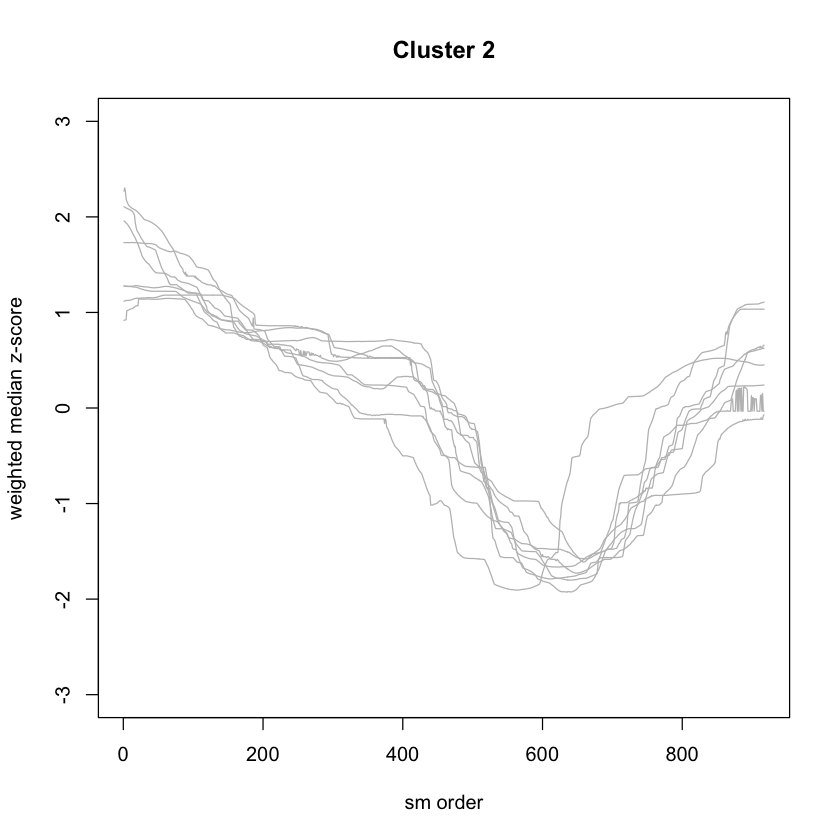

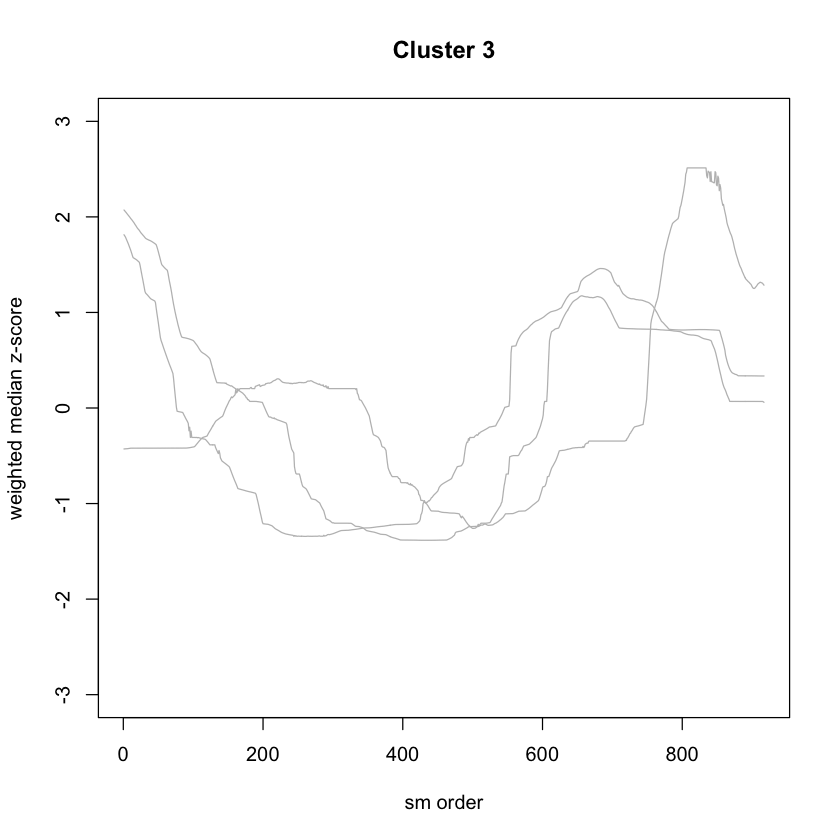

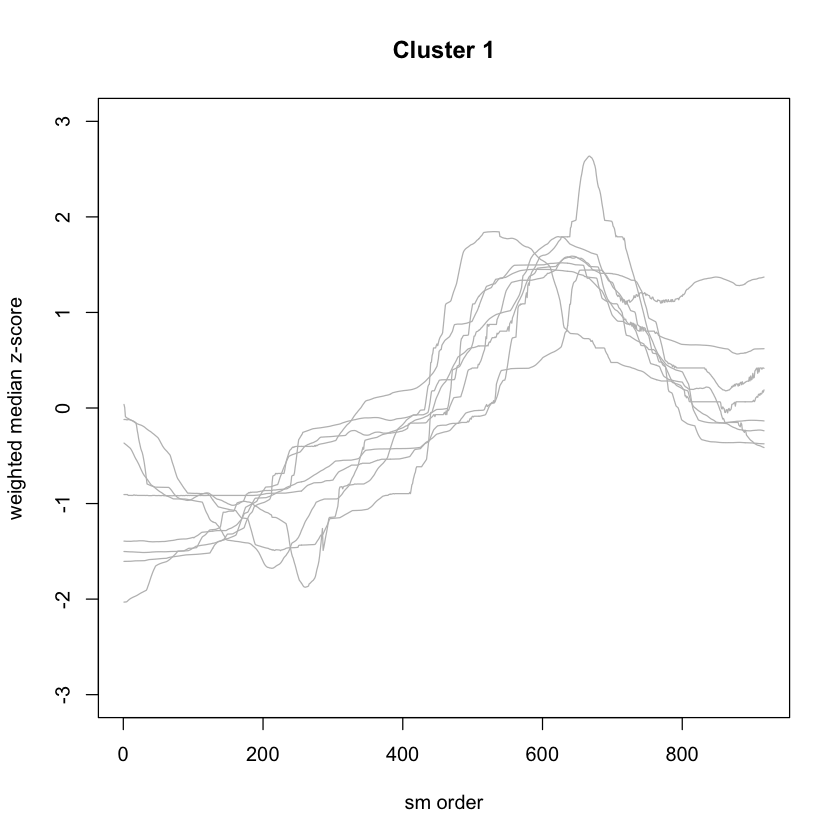

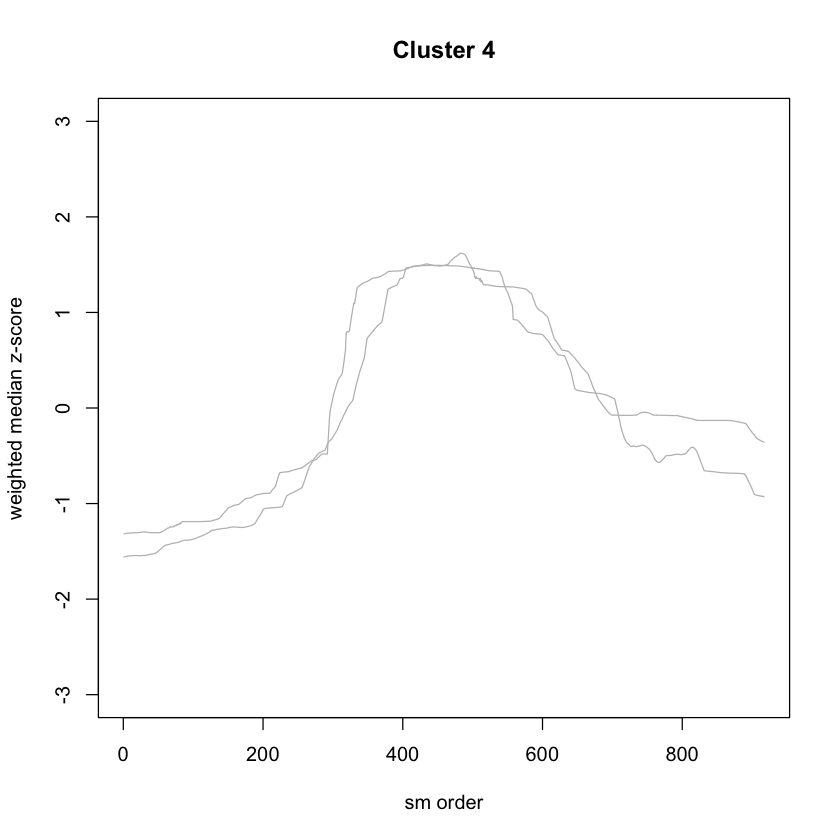

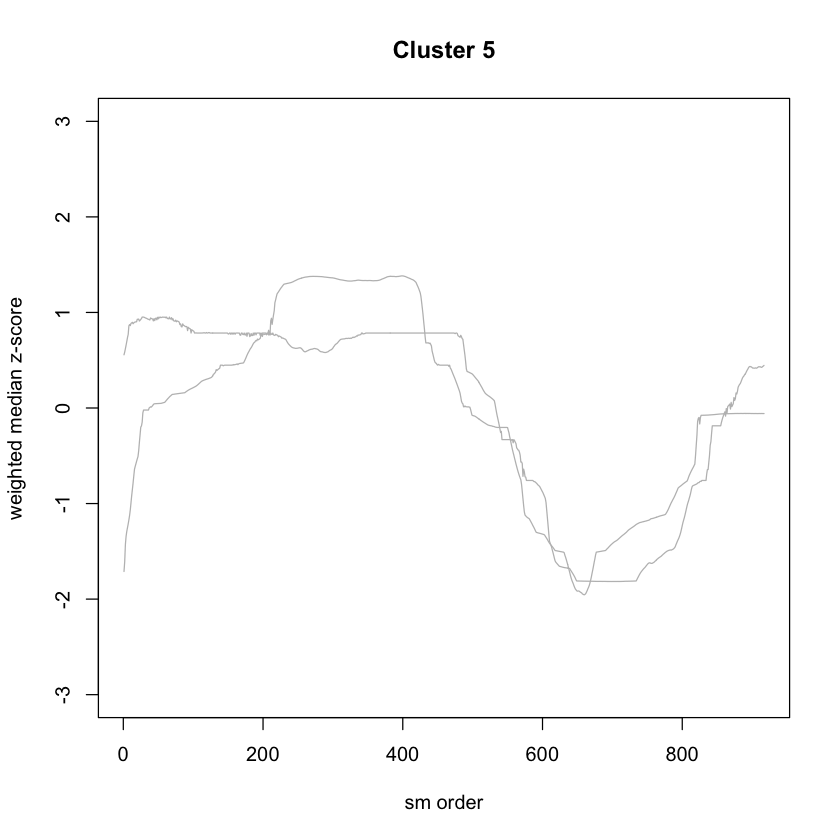

In [12]:
for (cluster in unique(sm_gene_clusters)){
  plot(NA, ylim = c(-3, 3), xlim = c(1,dim(sm_sequence_df)[2]), main=paste('Cluster',cluster, sep=' '), ylab='weighted median z-score', xlab='sm order')
  for(i in which(sm_gene_clusters==cluster)){
    # z-scale sequence
    plot_sequence <- as.numeric(sm_sequence_df[i,])
    plot_sequence <- (plot_sequence - mean(plot_sequence))/(sd(plot_sequence))
    
    lines(plot_sequence, type = "l", col='grey') 
  }
}

#### Plot line plots of gene expression - pressure associations for all clusters

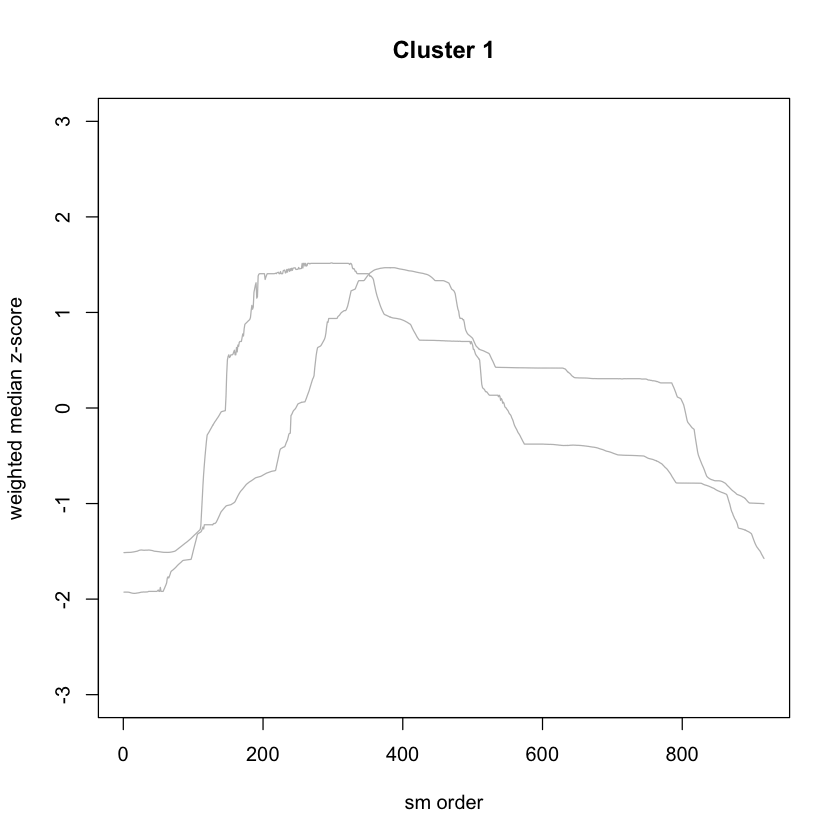

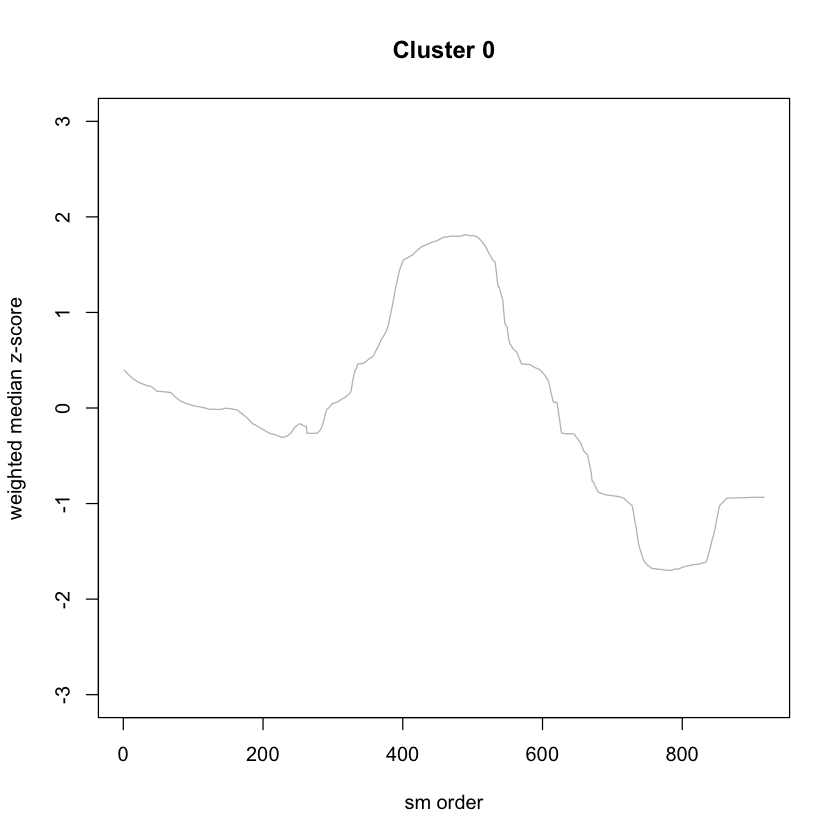

In [13]:
for (cluster in unique(p_gene_clusters)){
  plot(NA, ylim = c(-3, 3), xlim = c(1,dim(p_sequence_df)[2]), main=paste('Cluster',cluster, sep=' '), ylab='weighted median z-score', xlab='sm order')
  for(i in which(p_gene_clusters==cluster)){
    # z-scale sequence
    plot_sequence <- as.numeric(p_sequence_df[i,])
    plot_sequence <- (plot_sequence - mean(plot_sequence))/(sd(plot_sequence))
    
    lines(plot_sequence, type = "l", col='grey') 
  }
}

### Further analysis - GO overrepresentation analysis of genes in scHOT clusters

#### GO overrepresentation analysis for stress tensor magnitude clusters

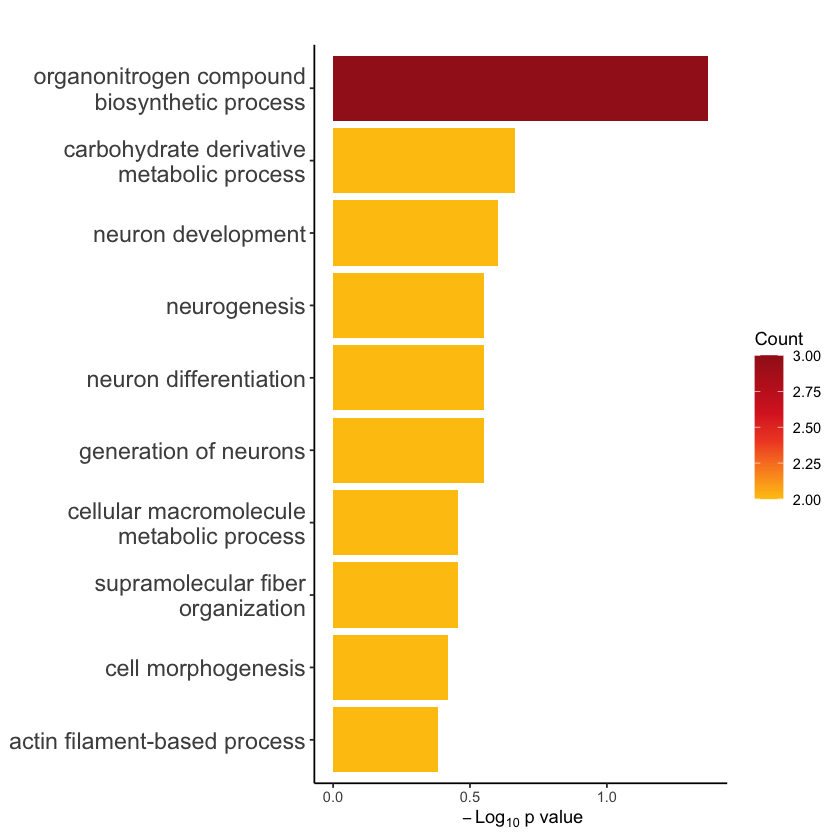

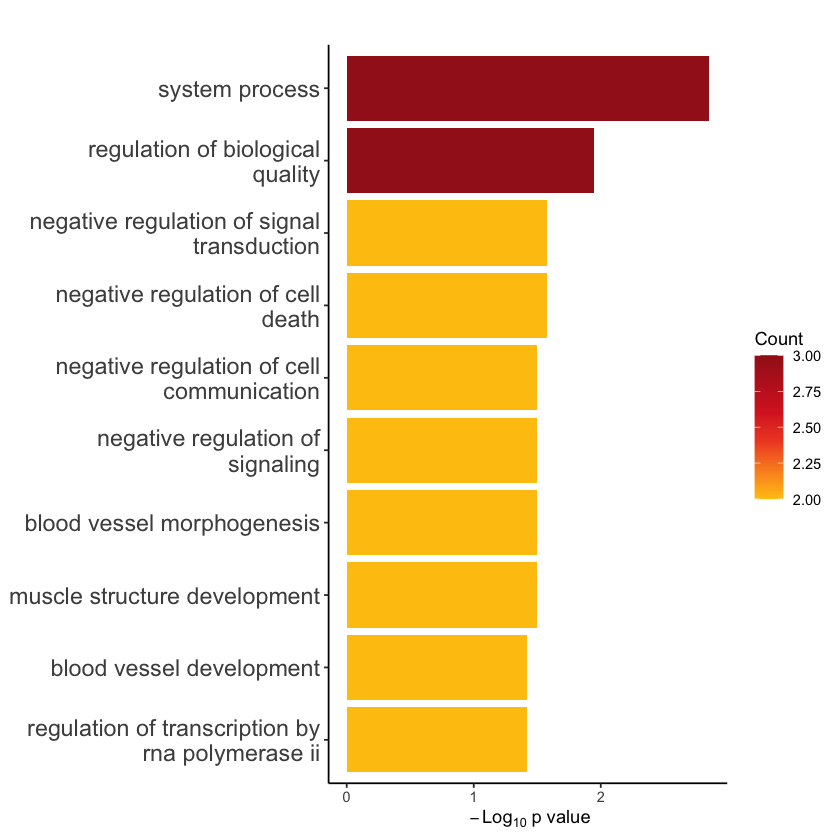

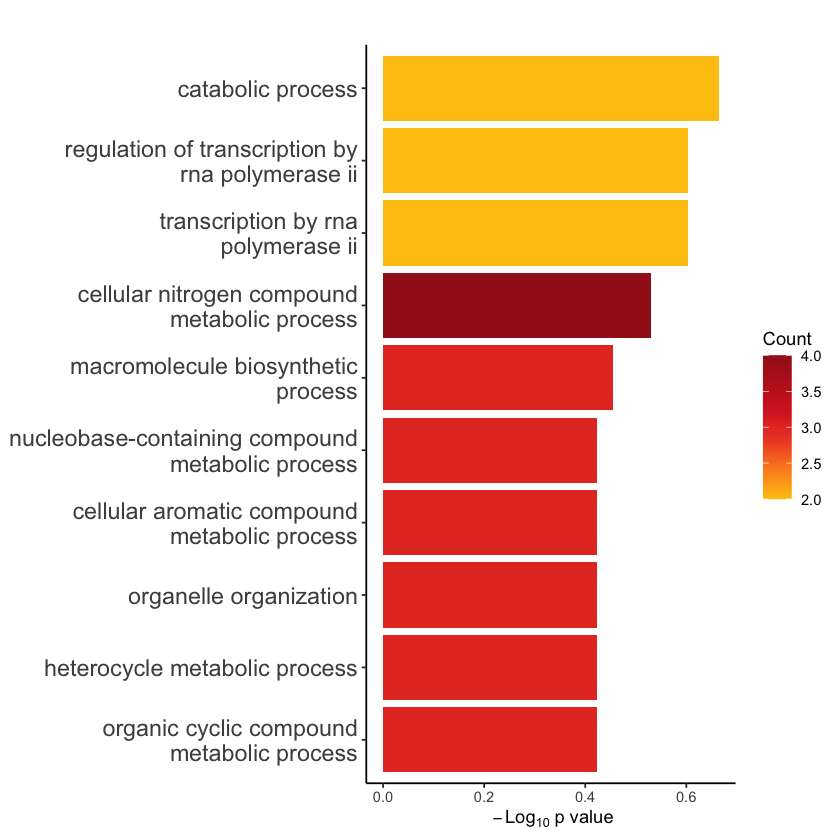

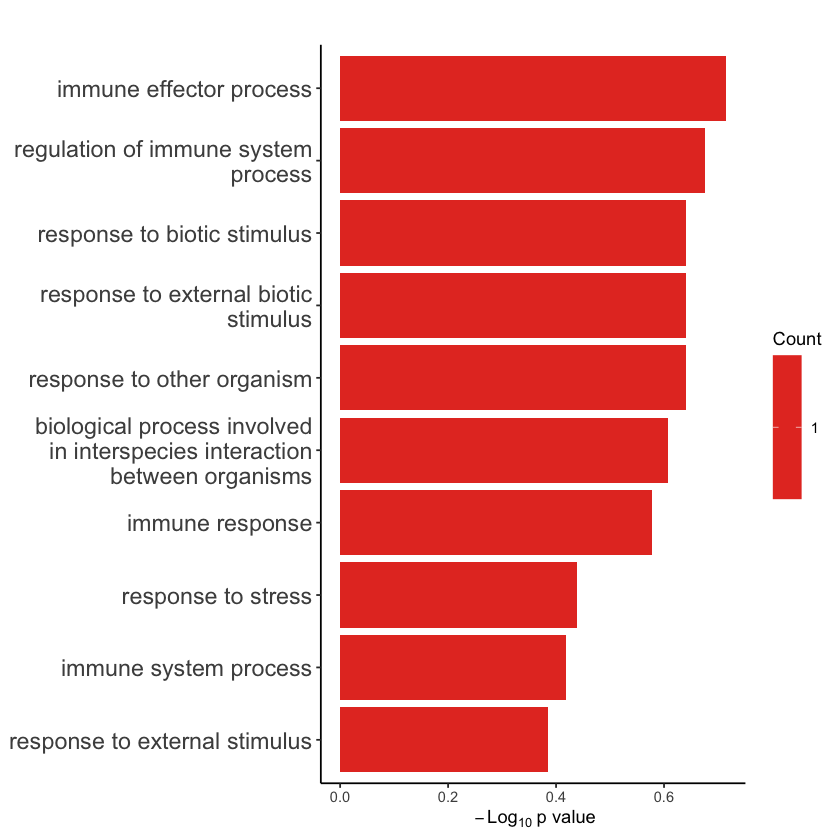

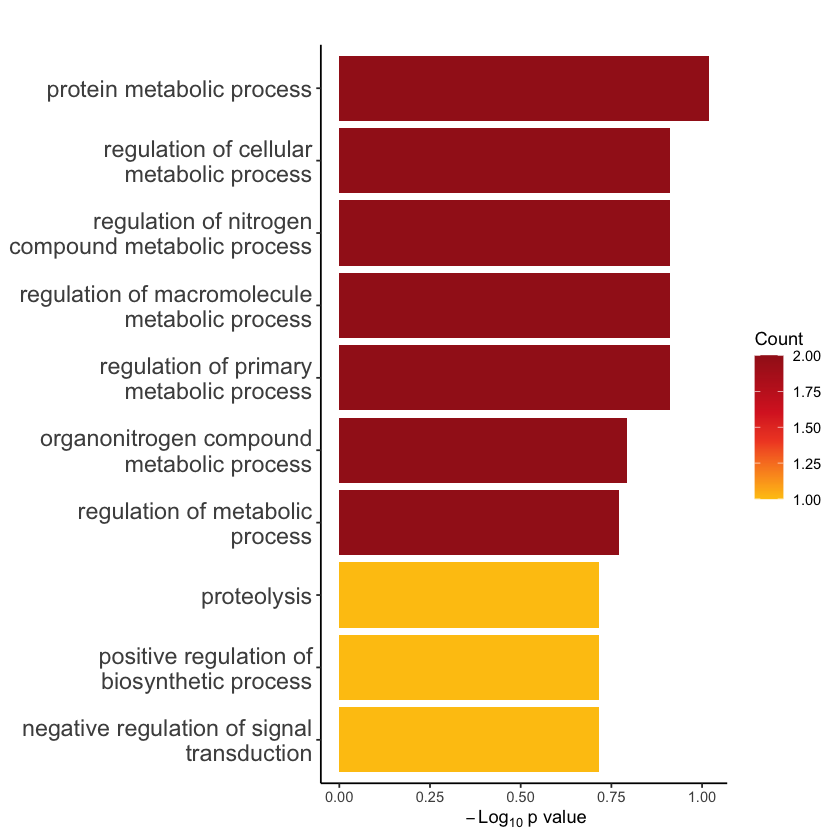

In [14]:
for (cluster in unique(sm_gene_clusters)){
  cluster_genes <- rownames(sm_sequence_df)[sm_gene_clusters==cluster]
  go_res <- enrichGO(gene      = cluster_genes,
                     universe     = var_genes_subset,
                     OrgDb        = org.Mm.eg.db,
                     ont          = "BP",
                     keyType      = "SYMBOL", 
                     minGSSize    = 10,
                     maxGSSize    = 500,
                     pvalueCutoff = 0.2)
  p<-makebarplot(go_res@result, title = '', 10)
  print(p)
}

#### GO overrepresentation analysis for pressure clusters

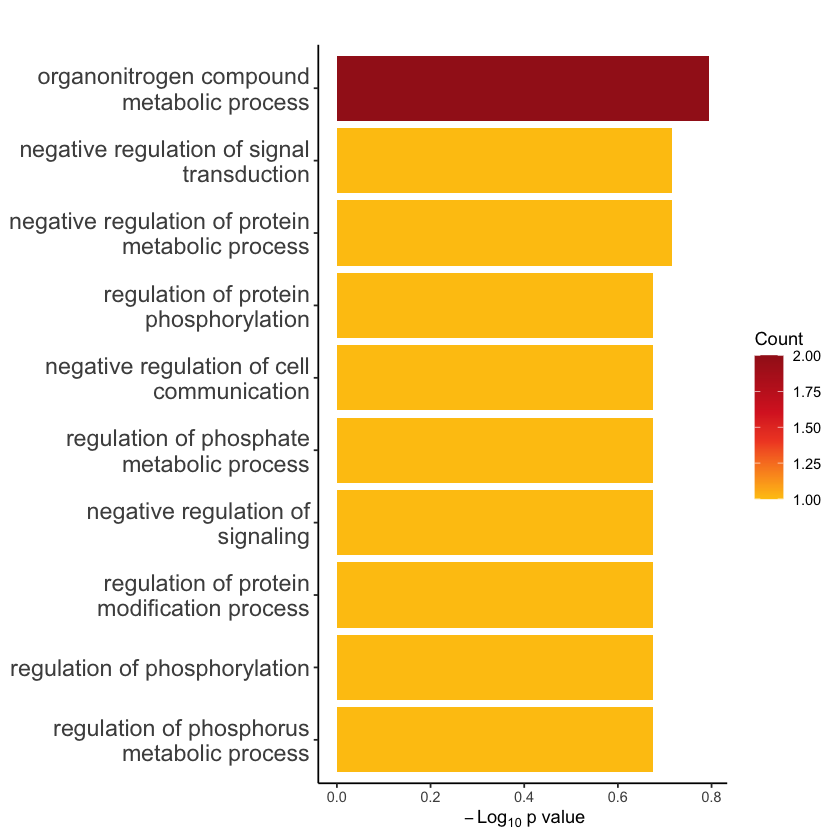

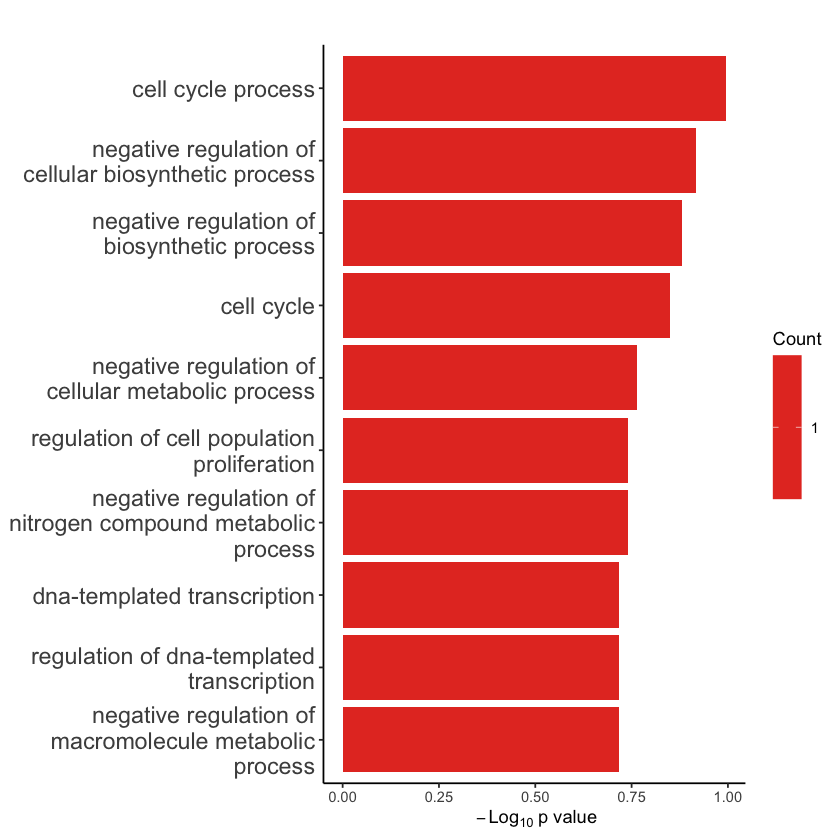

In [15]:
for (cluster in unique(p_gene_clusters)){
  cluster_genes <- rownames(p_sequence_df)[p_gene_clusters==cluster]
  go_res <- enrichGO(gene      = cluster_genes,
                     universe     = var_genes_subset,
                     OrgDb        = org.Mm.eg.db,
                     ont          = "BP",
                     keyType      = "SYMBOL", 
                     minGSSize    = 10,
                     maxGSSize    = 500,
                     pvalueCutoff = 0.2)
  p<-makebarplot(go_res@result, title = '', 10)
  print(p)
}

#### Environment information:

In [16]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/rhe/.conda/envs/tensionmap/lib/libopenblasp-r0.3.24.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Mm.eg.db_3.16.0   AnnotationDbi_1.60.0  IRanges_2.32.0       
 [4] S4Vectors_0.36.0      Biobase_2.58.0        BiocGenerics_0.44.0  
 [7] clusterProfiler_4.6.0 dynamicTreeCut_1.63-1 doParallel_1.0.17    
[10] iterators_1.0.14      foreach_1.5.2         BuenColors_0.5.6     
[13] MASS_7.3-60           stringr_1.5.0         ggplot2_3.4.3        
[16] dplyr_1.1.1           scHOT_1.10.0         

loaded via a namespace (and not attached):
  [1] fgsea_1.24.0                colorspace_2.1-0           
  [3] ggtree_3.6.0                gson_0.1.0     